In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.metrics import r2_score
import pdb
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#导入数据集
train_data = pd.read_csv('train.csv',header=0)
#删除异常点数据
i_=[]
for i in range(len(train_data)):
    if train_data['MEDV'][i]== 50:
        i_.append(i)
for i in range(len(i_)):
    train_data=train_data.drop(i_[i])
train_y = train_data['MEDV']
train_x = train_data.drop('MEDV', axis = 1)
#数据归一化
test_data = pd.read_csv('test.csv')
test_y = pd.read_csv('submission.csv')
test_y = test_y['MEDV']
test_x = test_data.drop('id', axis = 1) 
#归一化处理
mean = train_x.mean(axis=0)
std = train_x.std(axis=0)
train_x = (train_x - mean) / std
test_x = (test_x - mean) / std
#数组初始化
test_list=[]#每个epoch对测试集的mse
all_val_mse = []#每个epoch对验证集的mse
all_test_mse = [15]#第i折最后对测试集的mse 作为最好模型评估
#输出路径初始化
path = r'../output/logs/'
if not os.path.exists(path):
    os.makedirs(path)
    print("创建目录")
else:
    print("目录已存在")
#回调加动态学习率、评价指标、保存最好模型
class MyCallback(keras.callbacks.Callback):
    def __init__(self,training_data,validation_data,testing_data):       
        self.x = training_data[0]
        self.y = training_data[1]
        self.xx = validation_data[0]
        self.yy = validation_data[1]
        self.xxx = testing_data[0]
        self.yyy = testing_data[1]
        #pdb.set_trace()
    
    def on_train_begin(self, logs={}):
        return
    def on_train_end(self, epoch,logs={}):
        return
    def on_epoch_end(self, epoch, logs={}):
        test_mse_score = model.evaluate(self.xxx, self.yyy); #评估模型
        if test_mse_score < 20:
            test_list.append(test_mse_score);
            if test_mse_score < all_test_mse[len(all_test_mse)-1]:
                model.save(os.path.join(path,'best_model.h5'))
                all_test_mse.append(test_mse_score)
                print("目前最优test_mse为%.3f" %test_mse_score)
        return

def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64,activation=tf.nn.relu,input_shape=(train_x.shape[1],)),
#        Dropout(0.1),
        keras.layers.Dense(64,activation=tf.nn.relu),
#        Dropout(0.1),
        keras.layers.Dense(1)
    ])
    optimizer = keras.optimizers.Adam()
    
    model.compile(loss = 'mse',
                 optimizer = optimizer)
    return model

k=4
num_val_samples = len(train_x) // k
num_epochs = 500
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto')
eraly_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=80, verbose=0)
for i in range(k):
    print('第', i+1 ,'折')
    val_x = train_x[i*num_val_samples : (i+1)*num_val_samples]#划出验证集部分
    val_y = train_y[i*num_val_samples : (i+1)*num_val_samples]
    
    partial_train_x = np.concatenate([train_x[:i*num_val_samples],train_x[(i+1)*num_val_samples:]],axis=0)
    partial_train_y = np.concatenate([train_y[:i*num_val_samples], train_y[(i+1)*num_val_samples:]],axis=0)
    
    model = build_model()
    
    history = model.fit(partial_train_x, partial_train_y, epochs = num_epochs, batch_size=8,verbose = 2,
                        callbacks = [MyCallback(training_data=[partial_train_x,partial_train_y],validation_data=[val_x,val_y],
                                               testing_data=[test_x,test_y]),
                                     reduce_lr,
                                     eraly_stopping],
                        validation_data = (val_x,val_y) )

    print(history.history.keys())
    #pdb.set_trace()
    val_loss = history.history['val_loss']#记录验证集数据
    all_val_mse.append(val_loss[len(val_loss)-1])
    #test_mse_score = model.evaluate(test_x, test_y) #评估模型
    #all_test_mse.append(test_mse_score)
    #print('test_mse = ',test_mse_score)
model.summary()
print("最优test_mse为%.3f" %all_test_mse[len(all_test_mse)-1])
np.save(os.path.join(path,'all_val_mse.npy'),all_val_mse)
np.save(os.path.join(path,'all_test_mse.npy'),all_test_mse)
np.save(os.path.join(path,'test_list.npy'),test_list)
y_pred = model.predict(test_x ,batch_size = 1)
df = pd.DataFrame(y_pred)
df.to_csv(os.path.join(path,'ownsubmissionAdam.csv'))



D:\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

目录已存在
第 1 折
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 293 samples, validate on 97 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
102/102 [==============================] - 0s 68us/sample - loss: 289.5245
 - 2s - loss: 422.9639 - val_loss: 289.1825
Epoch 2/500
102/102 [==============================] - 0s 59us/sample - loss: 65.3873
 - 0s - loss: 179.9990 - val_loss: 67.2290
Epoch 3/500
102/102 [==============================] - 0s 68us/sample - loss: 38.0276
 - 0s - loss: 45.7393 - val_loss: 38.5972
Epoch 4/500
102/102 [==============================] - 0s 59us/sample - loss: 28.6632
 - 0s - loss: 25.7303 - val_loss: 27.7968
Epoch 5/500
102/102 [==============================] - 0s 68us/sample - loss: 24.6792
 - 0s - loss: 19.0637 - val_loss: 23.4448
Epoch 6/500
102/102 [==============================] - 0s 59us/sample - loss: 21.8012
 - 0s - loss: 15.9357 - val_loss: 20.0886
Epo

Epoch 57/500
102/102 [==============================] - 0s 49us/sample - loss: 13.7018
 - 0s - loss: 4.0435 - val_loss: 6.7435
Epoch 58/500
102/102 [==============================] - 0s 59us/sample - loss: 13.0387
目前最优test_mse为13.039
 - 0s - loss: 3.8992 - val_loss: 6.5655
Epoch 59/500
102/102 [==============================] - 0s 49us/sample - loss: 13.0493
 - 0s - loss: 3.7725 - val_loss: 6.6575
Epoch 60/500
102/102 [==============================] - 0s 49us/sample - loss: 13.1538
 - 0s - loss: 4.1201 - val_loss: 6.3613
Epoch 61/500
102/102 [==============================] - 0s 49us/sample - loss: 13.1754
 - 0s - loss: 3.8443 - val_loss: 6.6622
Epoch 62/500
102/102 [==============================] - 0s 49us/sample - loss: 13.2828
 - 0s - loss: 3.8246 - val_loss: 6.3355
Epoch 63/500
102/102 [==============================] - 0s 59us/sample - loss: 12.9634
目前最优test_mse为12.963
 - 0s - loss: 3.8352 - val_loss: 6.3348
Epoch 64/500
102/102 [==============================] - 0s 49us/sample 

102/102 [==============================] - 0s 98us/sample - loss: 12.6291
 - 0s - loss: 2.5511 - val_loss: 5.7293
Epoch 120/500
102/102 [==============================] - 0s 88us/sample - loss: 12.6615
 - 0s - loss: 2.7932 - val_loss: 5.8565
Epoch 121/500
102/102 [==============================] - 0s 88us/sample - loss: 12.3387
 - 0s - loss: 2.4959 - val_loss: 5.5130
Epoch 122/500
102/102 [==============================] - 0s 98us/sample - loss: 12.6982
 - 0s - loss: 2.4533 - val_loss: 5.8199
Epoch 123/500
102/102 [==============================] - 0s 88us/sample - loss: 12.4669
 - 0s - loss: 2.4019 - val_loss: 5.4386
Epoch 124/500
102/102 [==============================] - 0s 88us/sample - loss: 12.5711
 - 0s - loss: 2.3630 - val_loss: 5.7555
Epoch 125/500
102/102 [==============================] - 0s 108us/sample - loss: 12.1919
 - 0s - loss: 2.4118 - val_loss: 5.3895
Epoch 126/500
102/102 [==============================] - 0s 98us/sample - loss: 12.6167
 - 0s - loss: 2.5565 - val_lo

102/102 [==============================] - 0s 88us/sample - loss: 12.1931
 - 0s - loss: 1.7610 - val_loss: 5.4434
Epoch 184/500
102/102 [==============================] - 0s 88us/sample - loss: 12.2198
 - 0s - loss: 1.7440 - val_loss: 5.4646
Epoch 185/500
102/102 [==============================] - 0s 88us/sample - loss: 12.2122
 - 0s - loss: 1.7379 - val_loss: 5.4584
Epoch 186/500
102/102 [==============================] - 0s 98us/sample - loss: 12.2033
 - 0s - loss: 1.7492 - val_loss: 5.4401
Epoch 187/500
102/102 [==============================] - 0s 88us/sample - loss: 12.2181
 - 0s - loss: 1.7387 - val_loss: 5.4711
Epoch 188/500
102/102 [==============================] - 0s 68us/sample - loss: 12.2103
 - 0s - loss: 1.7383 - val_loss: 5.4625
Epoch 189/500
102/102 [==============================] - 0s 78us/sample - loss: 12.2031
 - 0s - loss: 1.7394 - val_loss: 5.4483
Epoch 190/500
102/102 [==============================] - 0s 78us/sample - loss: 12.2053
 - 0s - loss: 1.7360 - val_los

102/102 [==============================] - 0s 78us/sample - loss: 18.5617
 - 0s - loss: 8.5063 - val_loss: 8.8765
Epoch 14/500
102/102 [==============================] - 0s 88us/sample - loss: 17.8094
 - 0s - loss: 8.0148 - val_loss: 9.1445
Epoch 15/500
102/102 [==============================] - 0s 78us/sample - loss: 17.7692
 - 0s - loss: 7.6268 - val_loss: 8.6868
Epoch 16/500
102/102 [==============================] - 0s 68us/sample - loss: 17.3515
 - 0s - loss: 7.4250 - val_loss: 8.7617
Epoch 17/500
102/102 [==============================] - 0s 88us/sample - loss: 17.4866
 - 0s - loss: 7.1129 - val_loss: 8.4394
Epoch 18/500
102/102 [==============================] - 0s 78us/sample - loss: 17.2690
 - 0s - loss: 6.8317 - val_loss: 8.5432
Epoch 19/500
102/102 [==============================] - 0s 68us/sample - loss: 17.4355
 - 0s - loss: 6.6462 - val_loss: 8.0859
Epoch 20/500
102/102 [==============================] - 0s 78us/sample - loss: 16.9963
 - 0s - loss: 6.3606 - val_loss: 8.06

102/102 [==============================] - 0s 88us/sample - loss: 16.1032
 - 0s - loss: 3.8423 - val_loss: 8.4668
Epoch 78/500
102/102 [==============================] - 0s 88us/sample - loss: 16.1166
 - 0s - loss: 3.8581 - val_loss: 8.4723
Epoch 79/500
102/102 [==============================] - 0s 98us/sample - loss: 16.0869
 - 0s - loss: 3.8390 - val_loss: 8.4904
Epoch 80/500
102/102 [==============================] - 0s 98us/sample - loss: 16.1352
 - 0s - loss: 3.8384 - val_loss: 8.4977
Epoch 81/500
102/102 [==============================] - 0s 88us/sample - loss: 16.1068
 - 0s - loss: 3.8348 - val_loss: 8.5039
Epoch 82/500
102/102 [==============================] - 0s 88us/sample - loss: 16.1049
 - 0s - loss: 3.8269 - val_loss: 8.5117
Epoch 83/500
102/102 [==============================] - 0s 88us/sample - loss: 16.1103
 - 0s - loss: 3.8346 - val_loss: 8.4931
Epoch 84/500
102/102 [==============================] - 0s 98us/sample - loss: 16.1031
 - 0s - loss: 3.8197 - val_loss: 8.51

Epoch 31/500
102/102 [==============================] - 0s 88us/sample - loss: 17.1262
 - 0s - loss: 5.3040 - val_loss: 7.1889
Epoch 32/500
102/102 [==============================] - 0s 78us/sample - loss: 16.5354
 - 0s - loss: 5.2719 - val_loss: 6.9385
Epoch 33/500
102/102 [==============================] - 0s 78us/sample - loss: 17.5715
 - 0s - loss: 5.1458 - val_loss: 8.4525
Epoch 34/500
102/102 [==============================] - 0s 78us/sample - loss: 16.7717
 - 0s - loss: 5.5990 - val_loss: 7.2020
Epoch 35/500
102/102 [==============================] - 0s 78us/sample - loss: 17.1042
 - 0s - loss: 5.1172 - val_loss: 7.1012
Epoch 36/500
102/102 [==============================] - 0s 78us/sample - loss: 16.6552
 - 0s - loss: 4.9467 - val_loss: 7.0199
Epoch 37/500
102/102 [==============================] - 0s 98us/sample - loss: 16.9954
 - 0s - loss: 5.1279 - val_loss: 7.7204
Epoch 38/500
102/102 [==============================] - 0s 88us/sample - loss: 16.5515
 - 0s - loss: 5.0963 - v

102/102 [==============================] - 0s 78us/sample - loss: 16.4947
 - 0s - loss: 3.2029 - val_loss: 6.1815
Epoch 96/500
102/102 [==============================] - 0s 78us/sample - loss: 15.9330
 - 0s - loss: 3.2816 - val_loss: 5.8714
Epoch 97/500
102/102 [==============================] - 0s 88us/sample - loss: 16.4645
 - 0s - loss: 3.2061 - val_loss: 6.0606
Epoch 98/500
102/102 [==============================] - 0s 78us/sample - loss: 16.2673
 - 0s - loss: 3.2046 - val_loss: 5.8812
Epoch 99/500
102/102 [==============================] - 0s 78us/sample - loss: 16.2775
 - 0s - loss: 3.1263 - val_loss: 5.9126
Epoch 100/500
102/102 [==============================] - 0s 78us/sample - loss: 16.1813
 - 0s - loss: 3.1322 - val_loss: 6.0382
Epoch 101/500
102/102 [==============================] - 0s 78us/sample - loss: 16.1279
 - 0s - loss: 3.1213 - val_loss: 5.9052
Epoch 102/500
102/102 [==============================] - 0s 78us/sample - loss: 16.1801
 - 0s - loss: 3.0894 - val_loss: 5

102/102 [==============================] - 0s 98us/sample - loss: 16.1048
 - 0s - loss: 2.9000 - val_loss: 5.8563
Epoch 160/500
102/102 [==============================] - 0s 98us/sample - loss: 16.1037
 - 0s - loss: 2.8996 - val_loss: 5.8560
Epoch 161/500
102/102 [==============================] - 0s 108us/sample - loss: 16.1012
 - 0s - loss: 2.8994 - val_loss: 5.8553
Epoch 162/500
102/102 [==============================] - 0s 108us/sample - loss: 16.1046
 - 0s - loss: 2.8993 - val_loss: 5.8565
Epoch 163/500
102/102 [==============================] - 0s 98us/sample - loss: 16.1020
 - 0s - loss: 2.8992 - val_loss: 5.8558
Epoch 164/500
102/102 [==============================] - 0s 108us/sample - loss: 16.1014
 - 0s - loss: 2.8994 - val_loss: 5.8538
Epoch 165/500
102/102 [==============================] - 0s 88us/sample - loss: 16.1001
 - 0s - loss: 2.8989 - val_loss: 5.8531
Epoch 166/500
102/102 [==============================] - 0s 108us/sample - loss: 16.1020
 - 0s - loss: 2.8990 - val

102/102 [==============================] - 0s 88us/sample - loss: 15.0229
 - 0s - loss: 3.7153 - val_loss: 8.9493
Epoch 55/500
102/102 [==============================] - 0s 78us/sample - loss: 14.9109
 - 0s - loss: 3.6079 - val_loss: 8.5741
Epoch 56/500
102/102 [==============================] - 0s 78us/sample - loss: 15.1955
 - 0s - loss: 3.6789 - val_loss: 8.8768
Epoch 57/500
102/102 [==============================] - 0s 78us/sample - loss: 15.4914
 - 0s - loss: 3.6495 - val_loss: 8.5474
Epoch 58/500
102/102 [==============================] - 0s 78us/sample - loss: 14.9068
 - 0s - loss: 3.6485 - val_loss: 8.7299
Epoch 59/500
102/102 [==============================] - 0s 78us/sample - loss: 15.1804
 - 0s - loss: 3.5418 - val_loss: 8.6001
Epoch 60/500
102/102 [==============================] - 0s 88us/sample - loss: 15.1387
 - 0s - loss: 3.4581 - val_loss: 8.5181
Epoch 61/500
102/102 [==============================] - 0s 88us/sample - loss: 14.9753
 - 0s - loss: 3.3130 - val_loss: 8.69

102/102 [==============================] - 0s 78us/sample - loss: 14.8439
 - 0s - loss: 2.8354 - val_loss: 8.5702
Epoch 119/500
102/102 [==============================] - 0s 78us/sample - loss: 14.8383
 - 0s - loss: 2.8330 - val_loss: 8.5776
Epoch 120/500
102/102 [==============================] - 0s 78us/sample - loss: 14.8403
 - 0s - loss: 2.8358 - val_loss: 8.5737
Epoch 121/500
102/102 [==============================] - 0s 78us/sample - loss: 14.8392
 - 0s - loss: 2.8305 - val_loss: 8.5755
Epoch 122/500
102/102 [==============================] - 0s 78us/sample - loss: 14.8358
 - 0s - loss: 2.8312 - val_loss: 8.5767
Epoch 123/500
102/102 [==============================] - 0s 78us/sample - loss: 14.8425
 - 0s - loss: 2.8308 - val_loss: 8.5794
Epoch 124/500
102/102 [==============================] - 0s 78us/sample - loss: 14.8376
 - 0s - loss: 2.8293 - val_loss: 8.5740
Epoch 125/500
102/102 [==============================] - 0s 88us/sample - loss: 14.8358
 - 0s - loss: 2.8316 - val_los

[5.447029772493028, 8.511755852968601, 5.857898896502466, 8.573006957020496]
[15, 14.859270348268396, 14.570700860490986, 14.321835499183804, 13.81933707816928, 13.718132542628869, 13.514961546542597, 13.467071154538322, 13.446634554395489, 13.37276073998096, 13.32295433212729, 13.038697149239335, 12.963447982189702, 12.856189863354553, 12.822249417211495, 12.500402801177081, 12.451983208749809, 12.39808110629811, 12.384795717164582, 12.313365043378344, 12.196578904694201, 12.094548323575188]
最优test_mse为12.095
平均val_mse= (7.097)
平均test_mse= (13.247)


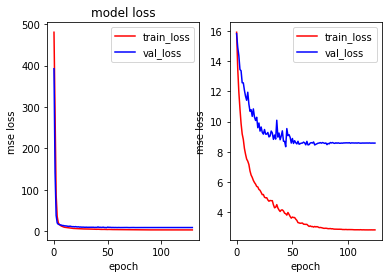

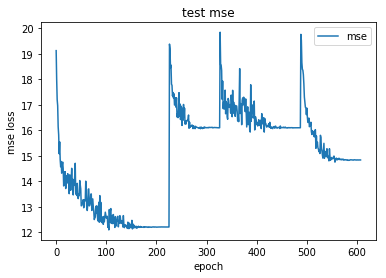

In [2]:
print (all_val_mse)
print (all_test_mse)
print("最优test_mse为%.3f" %all_test_mse[len(all_test_mse)-1])
print('平均val_mse= (%.3f)'% np.mean(np.array(all_val_mse)))
print('平均test_mse= (%.3f)'% np.mean(np.array(all_test_mse)))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'r', label ='train_loss' )
plt.plot(history.history['val_loss'], 'b', label='val_loss')
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'][5:], 'r', label ='train_loss' )
plt.plot(history.history['val_loss'][5:], 'b', label='val_loss')
#plt.xticks([0,1000],['5','1000'])
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
#plt.savefig('0.001,1000,8.png', dpi=200)
plt.show()

#plt.subplot(1,2,1)
plt.plot(test_list, label ='mse' )#训练中模型每epoch对测试集mse指标
plt.title('test mse')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()

plt.show()

In [ ]:
print(train_y.shape)

In [ ]:
column_headers = list(train_x.columns.values)
#分析异常点
for i in range(13):
    plt.figure(figsize=(55,55))
    plt.subplot(7,2,i+1)
    plt.scatter(train_x.values[:,i],train_y,s=20)
    plt.title(column_headers[i])
    plt.show()

In [ ]:
path = r'/home/output/logs/'

if not os.path.exists(path):
    os.makedirs(path)
    print("创建目录")
else:
    print("目录已存在")
hh=[123]
numpy.save(os.path.join(path,'hhh.npy'),hh)